In [19]:
import subprocess
import numpy as np
import random
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
from multiprocessing import Process
import time
import os

# Genetic Algorithm Parameters
POP_SIZE = 100      # Population size
N_GENERATIONS = 100   # Number of generations
TOURNAMENT_SIZE = 5  # Tournament selection (k=3)
CROSSOVER_RATE = 0.8 # Probability of crossover
MUTATION_RATE = 0.05 # Mutation probability per gene
ELITE_PERCENTAGE = 0.05 # Top 5% preserved

dna_dict = {}  # Empty dictionary

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(POP_SIZE)]
# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)

features_length = 500

def hamming_distance_list(list1, list2):
    # Ensure both lists are of the same length
    if len(list1) != len(list2):
        raise ValueError("Lists must be of the same length")
    
    # Calculate the Hamming distance by counting differing positions
    return sum(el1 != el2 for el1, el2 in zip(list1, list2))

def generate_individual(feature_count):
    """Creates a binary chromosome for feature selection."""
    return [random.randint(0, 1) for _ in range(feature_count)]


def evaluate_fitness(individual,target_indvidual):
    current_hamming_distance = hamming_distance_list(individual,target_indvidual)
    return(current_hamming_distance)

def tournament_selection(population, fitness_scores):
    """Selects a parent using tournament selection (k=3)."""
    competitors = random.sample(list(enumerate(fitness_scores)), TOURNAMENT_SIZE)
    best = min(competitors, key=lambda x: x[1])  # Select individual with best fitness
    return population[best[0]]

def uniform_crossover(parent1, parent2):
    """Performs uniform crossover (each gene has 50% chance of swapping)."""
    if random.random() < CROSSOVER_RATE:
        SWAP_PROBABILITY = 0.1
        child1 = [p1 if random.random() > SWAP_PROBABILITY else p2 for p1, p2 in zip(parent1, parent2)]
        child2 = [p2 if random.random() > SWAP_PROBABILITY else p1 for p1, p2 in zip(parent1, parent2)]
        return child1, child2
    return parent1[:], parent2[:]  # No crossover, children are copies

def mutate(individual):
    """Mutates an individual by flipping bits with a small probability."""
    return [1 - gene if random.random() < MUTATION_RATE else gene for gene in individual]

def plot_row_averages(df):
    """
    Plots the average and standard deviation of each row in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing numerical values.
    """
    row_averages = df.mean(axis=1)  # Compute the average across each row

    row_std = df.std(axis=1)  # Compute the standard deviation across each row
    
    plt.figure(figsize=(10, 5))
    
    # Plot row averages
    plt.plot(row_averages, marker='o', linestyle='-', color='b', label='Average AUC')
    
    # Plot the shaded region representing the standard deviation
    plt.fill_between(range(len(df)), row_averages - row_std, row_averages + row_std, color='b', alpha=0.2, label='Standard Deviation')
    
    plt.xlabel("Generation")
    plt.ylabel("Average hamming distance values")
    plt.title("Average feature set performance across generations")
    plt.legend()
    plt.grid(True)
    
    plt.show()

def hamming_distance(vector1, vector2):
    # Ensure both vectors are of the same length
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must be of the same length")
    
    # Use zip to iterate over both vectors and sum the differences
    return sum(el1 != el2 for el1, el2 in zip(vector1, vector2))

def plot_hamming_distance(input_dict):
    """ Plots the average hamming distance between all members of each generation
    Takes a dictionary corresponding to a list of lists
    """
    hamming_averages = []
    gen = []
    num_keys = len(input_dict)
    x = list(range(1, num_keys + 1))
    
    for i in x:
        current_list = input_dict[i]
        hamming_generation_values = []
        for p in range(len(current_list) - 1):
            relevant_comparisons = list(range(p, len(current_list)))
            for pop_member in relevant_comparisons:
                distance = hamming_distance(input_dict[i][p], input_dict[i][pop_member])
                hamming_generation_values.append(distance)
        current_hamming_average = sum(hamming_generation_values) / len(hamming_generation_values)
        hamming_averages.append(current_hamming_average)
        gen.append(i)

    # Plot gen averages for hamming distance
    plt.plot(hamming_averages, marker='o', linestyle='-', color='b', label='Average AUC')
    
    # Plot the shaded region representing the standard deviation
    
    plt.xlabel("Generation")
    plt.ylabel("Average Hamming distance values")
    plt.title("Average feature set hamming distance across generations")
    plt.legend()
    plt.grid(True)
    
    plt.show()

target_individual = generate_individual(features_length)

# Initialize population
population = [generate_individual(features_length) for _ in range(POP_SIZE)]
dna_dict[1] = population

# Evaluate initial fitness

fitness_scores = [evaluate_fitness(ind, target_individual) for ind in population]

best_fitness = min(fitness_scores)
print(f"Generation {1}, Best Hamming distance: {best_fitness:.4f}")

ga_df.loc[len(ga_df)] = fitness_scores

for gen in range(N_GENERATIONS):
    # Select the top individuals (elitism)
    elite_count = int(ELITE_PERCENTAGE * POP_SIZE)
    # Ensure we're selecting the individuals with the lowest fitness scores
    elites = [population[i] for i in np.argsort(fitness_scores)[:elite_count]]  # Keep individuals with lowest scores


    # Generate next generation
    new_population = elites[:]  # Start with elites

    while len(new_population) < POP_SIZE:
        # Select parents using tournament selection
        parent1 = tournament_selection(population, fitness_scores)
        parent2 = tournament_selection(population, fitness_scores)

        # Crossover to generate children
        child1, child2 = uniform_crossover(parent1, parent2)

        # Apply mutation
        child1 = mutate(child1)
        child2 = mutate(child2)

        # Add to new population (ensure we don't exceed population size)
        new_population.append(child1)
        if len(new_population) < POP_SIZE:
            new_population.append(child2)

    # Update population and fitness scores
    population = new_population
    current_generation = gen + 1
    dna_dict[current_generation] = new_population
    fitness_scores = [evaluate_fitness(ind, target_individual) for ind in population]

    ga_df.loc[len(ga_df)] = fitness_scores

    pickle.dump(dna_dict, open("dna_dict.pkl", "wb"))
    ga_df.to_pickle("ga_df.pkl")

    # Print best result every 10 generations
    if gen % 1 == 0:
        average_fitness = np.mean(fitness_scores)
        print(f"Generation {current_generation}, Average Hamming distance: {average_fitness:.4f}")

Generation 1, Best Hamming distance: 224.0000
Generation 1, Average Hamming distance: 259.4200
Generation 2, Average Hamming distance: 267.1000
Generation 3, Average Hamming distance: 272.1400
Generation 4, Average Hamming distance: 277.0500
Generation 5, Average Hamming distance: 282.3100
Generation 6, Average Hamming distance: 284.7500
Generation 7, Average Hamming distance: 286.1300
Generation 8, Average Hamming distance: 287.9400
Generation 9, Average Hamming distance: 290.7000
Generation 10, Average Hamming distance: 293.5900
Generation 11, Average Hamming distance: 296.3100
Generation 12, Average Hamming distance: 298.6900
Generation 13, Average Hamming distance: 301.4000
Generation 14, Average Hamming distance: 301.5200
Generation 15, Average Hamming distance: 303.3500
Generation 16, Average Hamming distance: 304.7700
Generation 17, Average Hamming distance: 304.4200
Generation 18, Average Hamming distance: 305.4300
Generation 19, Average Hamming distance: 306.2500
Generation 20

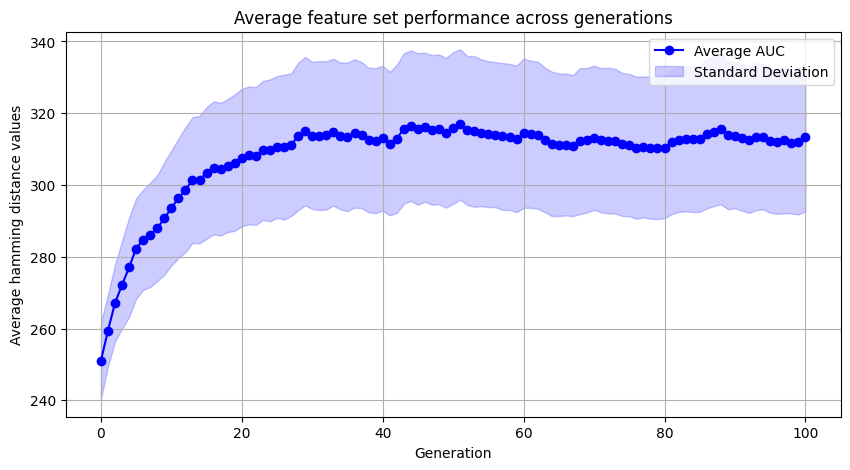

In [20]:
plot_row_averages(ga_df)

In [ ]:
plot_hamming_distance(dna_dict)